In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchmetrics import AUROC
import torch.nn.functional as F
from scipy import stats

from func2graph.data import data_simulator, generate_simulation_data
from func2graph import models, tools, baselines, data

In [4]:
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
})

### Construct Data

In [3]:
neuron_num = 200   #####################
tau = 1   ##################### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


init_scale = 0.2  #################
weight_scale = 0.2   #################
error_scale = 1  #################

total_time = 30000

data_random_seed=42 ######################

weight_type="cell_type"

test = False  ######################

simulator = data_simulator(
    neuron_num=neuron_num, 
    tau=tau, 
    weight_scale= weight_scale,
    init_scale=init_scale,
    error_scale=error_scale,
    total_time=total_time,
    data_random_seed=data_random_seed,
    weight_type=weight_type,
    test=test,
)

if test == False:
    result = []

    for t in range(total_time):
        x_t = simulator.forward(t)
        x_t = x_t.view(-1, 1)
        result.append(x_t)

    result = np.concatenate(result, axis=1)

    print(result.shape)

else:
    signal_result = []
    error_result = []

    for t in range(total_time):
        signal, error = simulator.forward(t)
        signal = signal.view(-1, 1)
        error = error.view(-1, 1)
        signal_result.append(signal)
        error_result.append(error)

    signal_result = np.concatenate(signal_result, axis=1)
    error_result = np.concatenate(error_result, axis=1)

    print(signal_result.shape)
    print(error_result.shape)

(200, 30000)


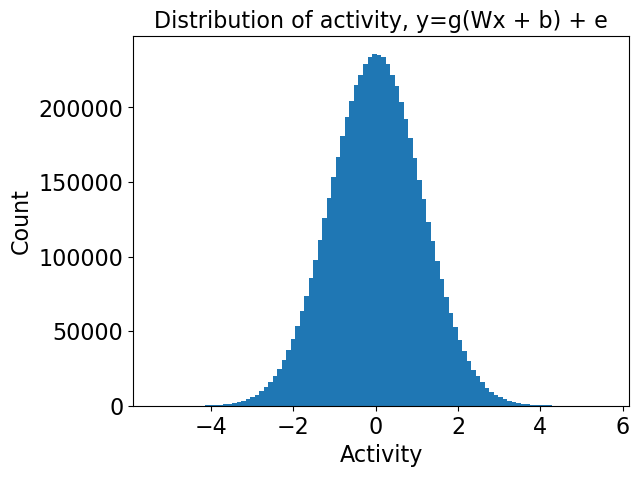

max activity:  5.6041265
min activity:  -5.3486137
medium activity:  0.0134688625


In [5]:
if test == True:
    for i in range(10):
        plt.subplot(10, 1, i+1)
        plt.plot(signal_result[i,:200])
    plt.show()

    for i in range(10):
        plt.subplot(10, 1, i+1)
        plt.plot(error_result[i,:200] + signal_result[i,:200])
    plt.show()

    plt.hist(signal_result.flatten(), bins=100)
    plt.show()
    plt.hist(error_result.flatten(), bins=100)
    plt.show()

else:
    plt.hist(result.flatten(), bins=100)
    plt.title("Distribution of activity, y=g(Wx + b) + e")
    plt.xlabel("Activity")
    plt.ylabel("Count")
    plt.show()

    # get the largest value of activity
    max_activity = np.max(result)
    print("max activity: ", max_activity)
    min_activity = np.min(result)
    print("min activity: ", min_activity)
    medium_activity = np.median(result)
    print("medium activity: ", medium_activity)

## Baselines

torch.Size([200, 30000])
val_data.shape:  torch.Size([5801, 200, 200])
tensor([[ 1.0233,  0.5935, -1.2659,  ...,  0.0241, -2.3161,  0.8213],
        [-0.8797,  1.4535, -0.5008,  ..., -0.1547,  0.5489,  0.8281],
        [ 2.2548,  1.6819, -3.1962,  ...,  0.9104,  0.0334,  2.3799],
        ...,
        [-0.0172,  0.1886,  0.5186,  ...,  1.7620,  0.1062,  0.0391],
        [-2.3137,  1.9204,  1.2398,  ...,  1.0783, -0.8347,  0.5856],
        [ 0.9877,  0.6830,  1.1217,  ...,  2.0125,  0.0441,  1.0597]])


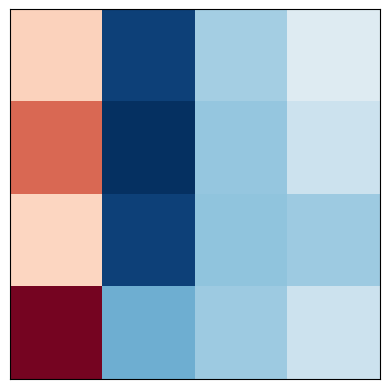

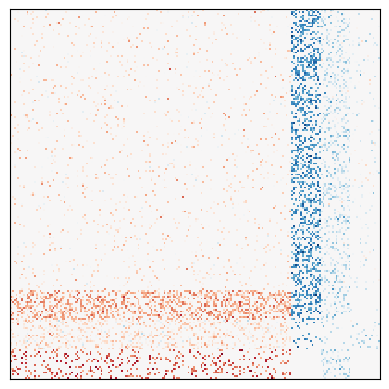

In [6]:
cell_type_id2cell_type = {0:'EC', 1:'Pvalb', 2:'Sst', 3:'Vip'}


window_size = 200
batch_size = 32
task_type = 'prediction'
predict_window_size = 1
data_type = 'wuwei'
spatial_partial_measurement = 200

data_result = data.generate_simulation_data(
    neuron_num=neuron_num,
    tau=tau,
    weight_scale=weight_scale,
    init_scale=init_scale,
    total_time=total_time,
    data_random_seed=data_random_seed,
    weight_type=weight_type,
    window_size=window_size,
    batch_size=batch_size,
    task_type=task_type,
    predict_window_size=predict_window_size,
    data_type=data_type,
    spatial_partial_measurement=spatial_partial_measurement,
)

trainloader, validloader, weight_matrix, b, cell_type_ids, cell_type_order, cell_type_count = data_result

strength_matrix = np.load('../../data/Mouse_Local_Connectivity/GT_strength_connectivity.npy')

max_abs = np.max(np.abs(strength_matrix))
vmin_KK = -max_abs
vmax_KK = max_abs
plt.imshow(strength_matrix, cmap='RdBu_r', interpolation='nearest', vmin=vmin_KK, vmax=vmax_KK)
plt.xticks([])
plt.yticks([])
plt.show()


weight_matrix = simulator.W_ij
weight_matrix = weight_matrix.detach().numpy()

max_abs = np.max(np.abs(weight_matrix))
vmin_NN = -max_abs
vmax_NN = max_abs
plt.imshow(weight_matrix, cmap='RdBu_r', interpolation='nearest', vmin=vmin_NN, vmax=vmax_NN)
plt.xticks([])
plt.yticks([])
plt.show()

### Covariance Matrix

(200, 200)


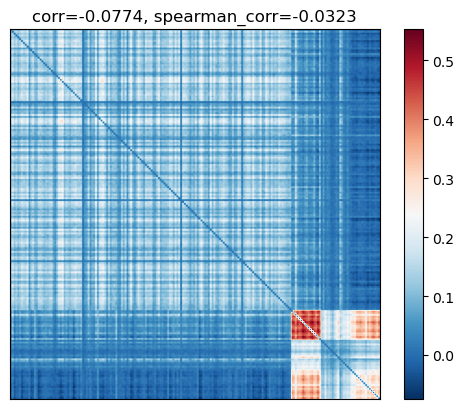

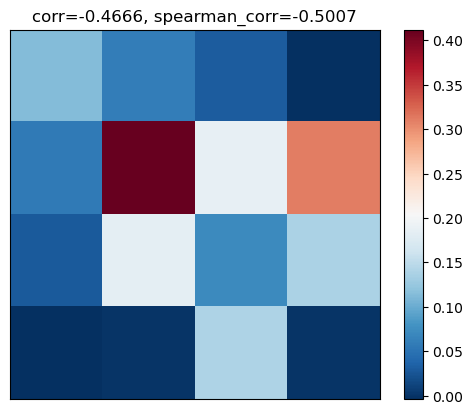

In [19]:
# calculate covariance matrix using activity

cov = np.cov(result)
cov = cov - np.diag(np.diag(cov)) 
print(cov.shape)
corr = np.corrcoef(cov.flatten(), weight_matrix.flatten())[0, 1]
spearman_corr = stats.spearmanr(cov.flatten(), weight_matrix.flatten())[0]

# only red color
plt.imshow(cov, cmap='RdBu_r')
plt.title("corr={:.4f}".format(corr) + ", spearman_corr={:.4f}".format(spearman_corr))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

KK_strength = tools.calculate_cell_type_level_connectivity_matrix_remove_no_connection(
    connectivity_matrix_new=cov,
    connectivity_matrix_GT=weight_matrix, 
    cell_type_id2cell_type=cell_type_id2cell_type,
    cell_type_count=cell_type_count
)
corr_strength_KK = np.corrcoef(KK_strength.flatten(), strength_matrix.flatten())[0, 1]
spearman_corr_strength_KK = stats.spearmanr(KK_strength.flatten(), strength_matrix.flatten())[0]

plt.imshow(KK_strength, cmap='RdBu_r')
plt.title("corr={:.4f}".format(corr_strength_KK) + ", spearman_corr={:.4f}".format(spearman_corr_strength_KK))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

### Cross Correlation

corr: 0.5457270910886914 spearman_corr: 0.4251705415709506


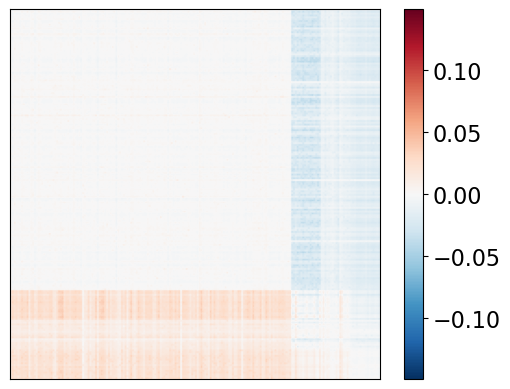

corr_strength_KK: 0.8147727927812135 spearman_corr_strength_KK: 0.578909184254291


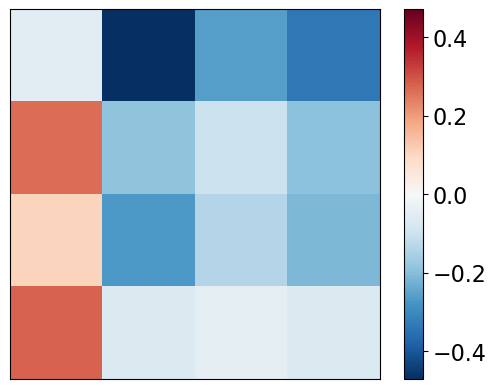

In [19]:
# get cross-correlation matrix
cross_corr = baselines.get_activity_cross_correlation_matrix(result, tau=1)   ########## tau

corr = np.corrcoef(cross_corr.flatten(), weight_matrix.flatten())[0, 1]
spearman_corr = stats.spearmanr(cross_corr.flatten(), weight_matrix.flatten())[0]
print('corr:', corr, 'spearman_corr:', spearman_corr)

transformed_cross_corr = tools.linear_transform(cross_corr, weight_matrix)
plt.imshow(transformed_cross_corr, cmap='RdBu_r', vmin=vmin_NN, vmax=vmax_NN)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

KK_strength = tools.calculate_cell_type_level_connectivity_matrix_remove_no_connection(
    connectivity_matrix_new=cross_corr,
    connectivity_matrix_GT=weight_matrix, 
    cell_type_id2cell_type=cell_type_id2cell_type,
    cell_type_count=cell_type_count
)
corr_strength_KK = np.corrcoef(KK_strength.flatten(), strength_matrix.flatten())[0, 1]
spearman_corr_strength_KK = stats.spearmanr(KK_strength.flatten(), strength_matrix.flatten())[0]
print('corr_strength_KK:', corr_strength_KK, 'spearman_corr_strength_KK:', spearman_corr_strength_KK)

transformed_KK_strength = tools.linear_transform(KK_strength, strength_matrix)
plt.imshow(transformed_KK_strength, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

### Transfer Entropy

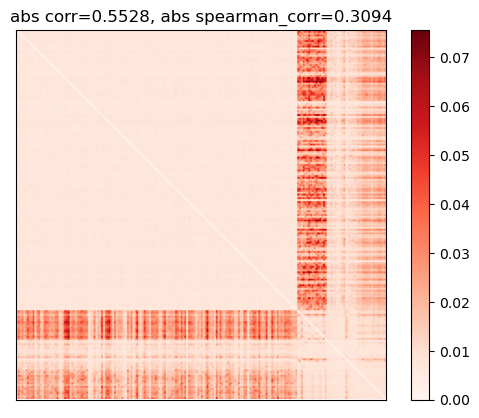

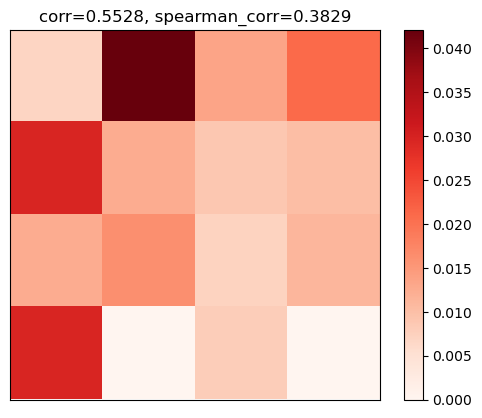

In [8]:
te = baselines.get_activity_transfer_entropy(result, history=1)   ########## tau

corr = np.corrcoef(te.flatten(), np.abs(weight_matrix).flatten())[0, 1]
spearman_corr = stats.spearmanr(te.flatten(), np.abs(weight_matrix).flatten())[0]

plt.imshow(te, cmap='Reds')
plt.title("abs corr={:.4f}".format(corr) + ", abs spearman_corr={:.4f}".format(spearman_corr))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

KK_strength = tools.calculate_cell_type_level_connectivity_matrix_remove_no_connection(
    connectivity_matrix_new=te,
    connectivity_matrix_GT=weight_matrix, 
    cell_type_id2cell_type=cell_type_id2cell_type,
    cell_type_count=cell_type_count
)
corr_strength_KK = np.corrcoef(KK_strength.flatten(), np.abs(strength_matrix).flatten())[0, 1]
spearman_corr_strength_KK = stats.spearmanr(KK_strength.flatten(), np.abs(strength_matrix).flatten())[0]

plt.imshow(KK_strength, cmap='Reds')
plt.title("abs corr={:.4f}".format(corr_strength_KK) + ", abs spearman_corr={:.4f}".format(spearman_corr_strength_KK))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

### Mutual Information

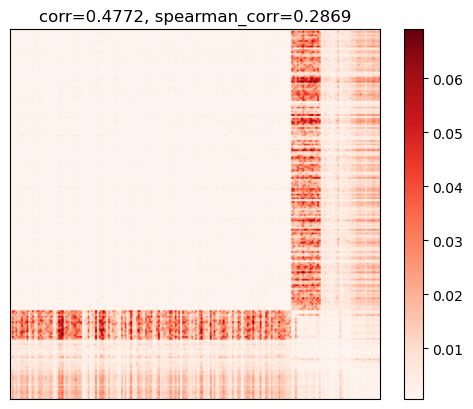

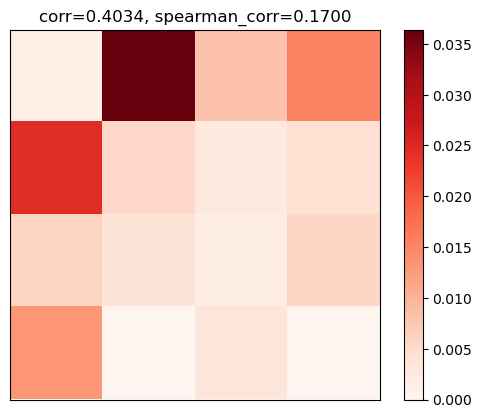

In [9]:
mi = baselines.get_activity_mutual_information(result, tau=1, bins=10)   ########## tau

corr = np.corrcoef(mi.flatten(), np.abs(weight_matrix).flatten())[0, 1]
spearman_corr = stats.spearmanr(mi.flatten(), np.abs(weight_matrix).flatten())[0]

plt.imshow(mi, cmap='Reds')
plt.title("corr={:.4f}".format(corr) + ", spearman_corr={:.4f}".format(spearman_corr))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

KK_strength = tools.calculate_cell_type_level_connectivity_matrix_remove_no_connection(
    connectivity_matrix_new=mi,
    connectivity_matrix_GT=weight_matrix, 
    cell_type_id2cell_type=cell_type_id2cell_type,
    cell_type_count=cell_type_count
)
corr_strength_KK = np.corrcoef(KK_strength.flatten(), np.abs(strength_matrix).flatten())[0, 1]
spearman_corr_strength_KK = stats.spearmanr(KK_strength.flatten(), np.abs(strength_matrix).flatten())[0]

plt.imshow(KK_strength, cmap='Reds')
plt.title("corr={:.4f}".format(corr_strength_KK) + ", spearman_corr={:.4f}".format(spearman_corr_strength_KK))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

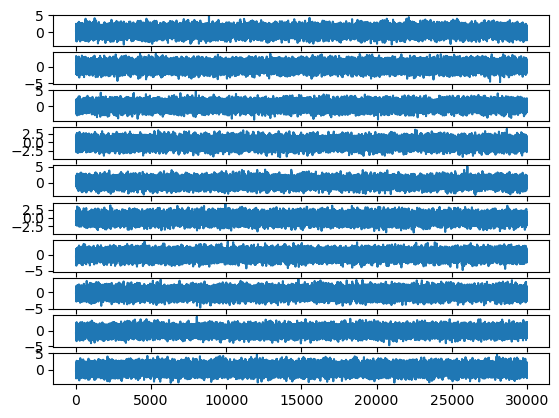

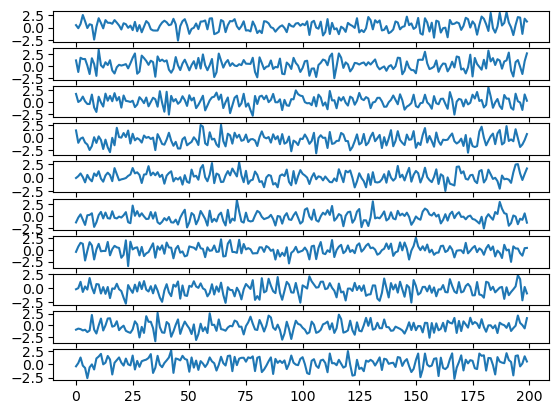

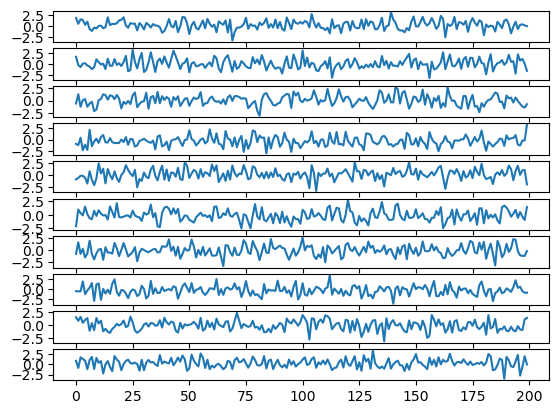

In [10]:
neuron_num = 10
for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i])
plt.show()

for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i][:200])
plt.show()

for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i][5000:5200])
plt.show()


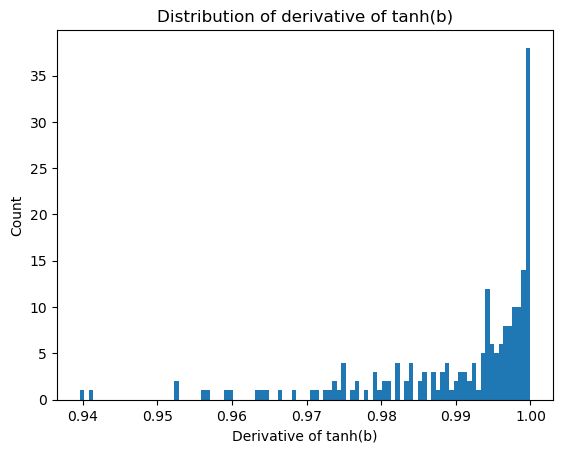

rank of the weight matrix:  200


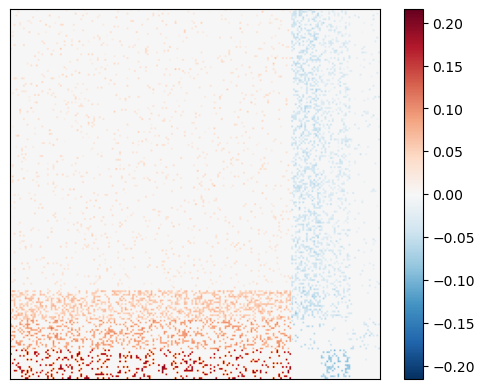

In [12]:
weight_matrix = simulator.W_ij

derivative_b = 1 - torch.tanh(simulator.b)**2
plt.hist(derivative_b.detach().numpy().flatten(), bins=100)
plt.title("Distribution of derivative of tanh(b)")
plt.xlabel("Derivative of tanh(b)")
plt.ylabel("Count")
plt.show()

# compute the rank of the weight matrix
rank = np.linalg.matrix_rank(weight_matrix.detach().numpy())
print("rank of the weight matrix: ", rank)

# choose the larger abs of min and max
max_abs = np.max(np.abs(weight_matrix.detach().numpy()))
plt.imshow(weight_matrix.detach().numpy(), cmap='RdBu_r', vmin=-max_abs, vmax=max_abs)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

torch.Size([200, 30000])
val_data.shape:  torch.Size([5801, 200, 200])
tensor([[-1.6911,  0.6748,  1.8291,  ...,  0.0242,  0.8528,  2.4147],
        [-1.2896,  1.0702, -0.8654,  ...,  1.6516,  2.1274, -1.5712],
        [-2.0636,  0.4282,  1.8470,  ...,  1.4348, -0.8813, -0.7332],
        ...,
        [-0.2945, -0.9614,  1.7570,  ..., -0.5612,  3.4060,  1.0130],
        [-0.5361, -0.8114,  2.7472,  ..., -0.8744,  0.4353,  1.4764],
        [-0.3347,  0.2065, -1.1262,  ..., -2.0218,  1.5395,  1.5110]])


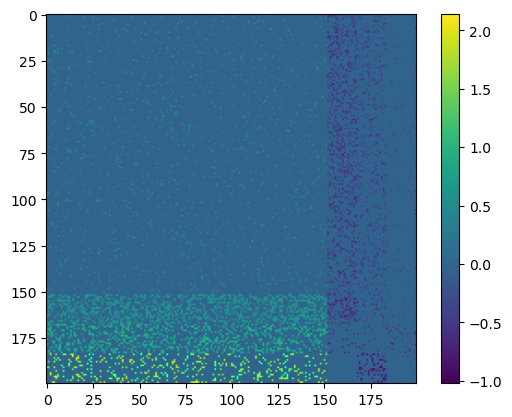

In [31]:
neuron_num = 200
dt = 0.001
tau = 0.3

spike_neuron_num=2
spike_input=20

random_seed=42
total_time = 30000

weight_type = "cell_type"

trainloader, validloader, weight_matrix, cell_type_ids, cell_type2id, cell_type_count = generate_simulation_data(
    neuron_num=neuron_num, 
    dt=dt, 
    tau=tau, 
    spike_neuron_num=spike_neuron_num, 
    spike_input=spike_input,
    data_random_seed=random_seed,
    total_time=total_time,
    weight_type=weight_type,
)

plt.imshow(weight_matrix.detach().numpy())
plt.colorbar()
plt.show()

torch.Size([32, 200, 200])


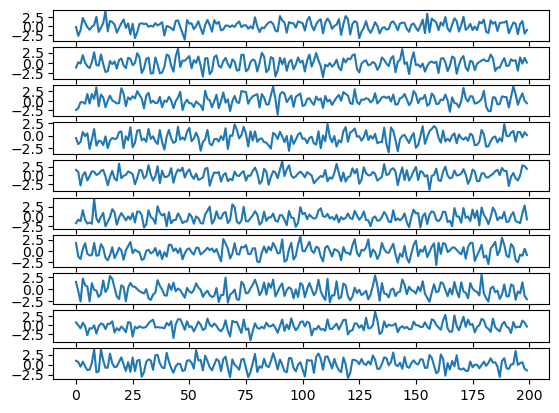

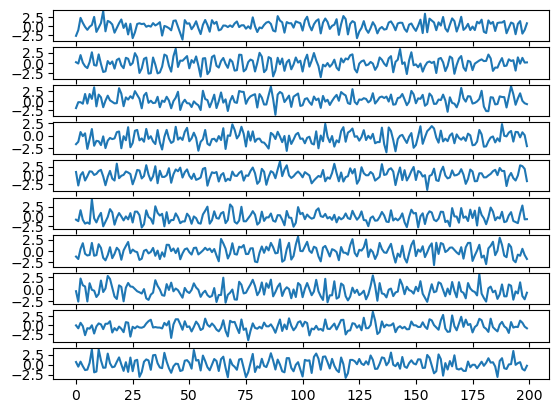

In [12]:
for i_batch, sample_batched in enumerate(trainloader):
    print(sample_batched[0].shape)
    samples = sample_batched[0][0:2]
    for i in range(10):
        plt.subplot(10, 1, i+1)
        plt.plot(samples[0][i])
    plt.show()
    for i in range(10):
        plt.subplot(10, 1, i+1)
        plt.plot(samples[1][i])
    plt.show()
    break